# Numbers of Patients Registered at a GP Practice
21/2/17
Number of patients registred with a particular GP who live in a particular LSOA (/via Carl Baker, HoC Library)

Demo sketch of opening data into an interactive *Google Map*.

In [ ]:
#Original data source
#http:§§//www.content.digital.nhs.uk/catalogue/PUB23139

In [1]:
#Get the datafile
!wget -P data http://www.content.digital.nhs.uk/catalogue/PUB23139/gp-reg-patients-LSOA-alt-tall.csv

--2017-02-21 14:02:29--  http://www.content.digital.nhs.uk/catalogue/PUB23139/gp-reg-patients-LSOA-alt-tall.csv
Resolving www.content.digital.nhs.uk... 194.189.27.28
Connecting to www.content.digital.nhs.uk|194.189.27.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38732373 (37M) [application/octet-stream]
Saving to: 'data/gp-reg-patients-LSOA-alt-tall.csv'

gp-reg-patients-LSO 100%[=====================>]  36.94M  1.45MB/s   in 30s    

2017-02-21 14:03:02 (1.22 MB/s) - 'data/gp-reg-patients-LSOA-alt-tall.csv' saved [38732373/38732373]



In [2]:
#Import best ever data handling package
import pandas as pd

In [3]:
#Load downloaded CSV file
df=pd.read_csv('data/gp-reg-patients-LSOA-alt-tall.csv')
#Preview first few lines
df.head()

,PRACTICE_CODE,NAME,LSOA_CODE,MALE_PATIENTS,FEMALE_PATIENTS,ALL_PATIENTS
0,A81001,THE DENSHAM SURGERY,E01012187,0,4,4
1,A81001,THE DENSHAM SURGERY,E01012188,42,45,87
2,A81001,THE DENSHAM SURGERY,E01012189,22,28,50
3,A81001,THE DENSHAM SURGERY,E01012190,63,86,149
4,A81001,THE DENSHAM SURGERY,E01012191,71,83,154


Previously, I have created a simple sqlite3 database containing administrative open data from NHS Digital ([database generator script](https://github.com/psychemedia/openHealthDataDoodles/blob/master/notebooks/NHS%20and%20GP%20Administrative%20Data.ipynb)).

Connect to local copy of the db.

In [ ]:
import sqlite3

#Use homebrew database of NHS administrative info
con = sqlite3.connect("nhsadmin.sqlite")

Look up the GP practices on the Isle of Wight... (We could search for the code but I happen to know it...)

In [44]:
ccode='10L'

#Find 
EPRACCUR='epraccur'
epraccur_iw = pd.read_sql_query('SELECT * FROM {typ} WHERE "Commissioner"="{ccode}"'.format(typ=EPRACCUR,ccode=ccode), con)

epraccur_iw

,Organisation Code,Name,National Grouping,High Level Health Geography,Address Line 1,Address Line 2,Address Line 3,Address Line 4,Address Line 5,Postcode,...,Close Date,Status Code,Organisation Sub-Type code,Commissioner,Join Provider/Purchaser Date,Left Provider/Purchaser Date,Contact Telephone Number,Amended Record Indicator,Provider/Purchaser,Prescribing Setting
0,J84003,VENTNOR MEDICAL CENTRE,Y57,Q70,VENTNOR MEDICAL CENTRE,3 ALBERT STREET,VENTNOR,ISLE OF WIGHT,None,PO38 1EZ,...,None,A,B,10L,2013-04-01 00:00:00,None,01983 857288,0,10L,4
1,J84004,EAST COWES MEDICAL CENTRE,Y57,Q70,EAST COWES MEDICAL CENTRE,CHURCH PATH,EAST COWES,ISLE OF WIGHT,None,PO32 6RP,...,None,A,B,10L,2013-04-01 00:00:00,None,01983 284333,0,10L,4
2,J84005,ESPLANADE SURGERY,Y57,Q70,THE ESPLANADE SURGERY,19 THE ESPLANADE,RYDE,ISLE OF WIGHT,None,PO33 2EH,...,None,A,B,10L,2013-04-01 00:00:00,None,01983 618388,0,10L,4
3,J84007,ST.HELENS MEDICAL CENTRE,Y57,Q70,ST.HELENS MEDICAL CENTRE,UPPER GREEN ROAD,ST.HELENS,ISLE OF WIGHT,None,PO33 1UG,...,None,A,B,10L,2013-04-01 00:00:00,None,01983 871828,0,10L,4
4,J84008,ARGYLL HOUSE,Y57,Q70,ARGYLL HOUSE,WEST STREET,RYDE,ISLE OF WIGHT,None,PO33 2QG,...,None,A,B,10L,2013-04-01 00:00:00,None,01983 562955,0,10L,4
5,J84010,SHANKLIN MEDICAL CENTRE,Y57,Q70,SHANKLIN MEDICAL CENTRE,CARTER ROAD,SHANKLIN,ISLE OF WIGHT,None,PO37 7HR,...,None,A,B,10L,2013-04-01 00:00:00,None,01983 862245,0,10L,4
6,J84011,CARISBROOKE HEALTH CENTRE,Y57,Q70,CARISBROOKE HEALTH CENTRE,22 CARISBROOKE HIGH ST.,"CARISBROOKE, NEWPORT",ISLE OF WIGHT,None,PO30 1NR,...,None,A,B,10L,2013-04-01 00:00:00,None,01983 522150,0,10L,4
7,J84012,TOWER HOUSE SURGERY,Y57,Q70,TOWER HOUSE SURGERY,RINK ROAD,RYDE,ISLE OF WIGHT,None,PO33 1LP,...,None,A,B,10L,2013-04-01 00:00:00,None,01983 817200,0,10L,4
8,J84013,SANDOWN HEALTH CENTRE,Y57,Q70,SANDOWN HEALTH CENTRE,BROADWAY,SANDOWN,ISLE OF WIGHT,None,PO36 9GA,...,None,A,B,10L,2013-04-01 00:00:00,None,01938 409292,0,10L,4
9,J84014,THE DOWER HOUSE,Y57,Q70,THE DOWER HOUSE,27 PYLE STREET,NEWPORT,ISLE OF WIGHT,None,PO30 1JW,...,None,A,B,10L,2013-04-01 00:00:00,None,01983 523525,0,10L,4


The `folium` library makes it easy to generate choropleth maps using the Leaflet javascript library. We can use various map tiles - the default is Google Maps.

In [57]:
import folium
#color brewer palettes: ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.

#Fiona is a powerful library for geo wrangling with various dependencies that can make installation a pain...
#...but I have it installed already so I can use it to trivially find the centre of a set of boundaries in a geojson file
import fiona

#This is a canned demo - I happen to have the Local Authority Code for the Isle of Wight...
#...and copies of LSOA geojson files by LA
# (I could get LA code from the NHS addmin db)
geojson_local='../../IWgeodata/lsoa_by_lad/E06000046.json'
fi=fiona.open(geojson_local)
centre_lat,centre_lon=((fi.bounds[0]+fi.bounds[2])/2,(fi.bounds[1]+fi.bounds[3])/2)

Generate a choropleth map for selected GP practice, colouring LSOA by number of folk registered to that practice.

In [65]:
#Add a widget in that lets you select the GP practice by name then fudge the lookup to practice code
#We could also add another widget to select eg Male | Female | All
def generate_map(gpcode):
    gpmap = folium.Map([centre_lon,centre_lat], zoom_start=11)
    gpmap.choropleth(
        geo_path=geojson_local,
        data=df[df['PRACTICE_CODE']==gpcode],
        columns=['LSOA_CODE', 'ALL_PATIENTS'],
        key_on='feature.properties.LSOA11CD',
        fill_color='PuBuGn', fill_opacity=0.7,
        legend_name='Number of people on list in LSOA'
        )
    
    return gpmap

def generate_map_from_gpname(gpname):
    gpcode=epraccur_iw[epraccur_iw['Name']==gpname]['Organisation Code'].iloc[0]
    return generate_map(gpcode)

In [66]:
#iw_gps=epraccur_iw['Organisation Code'].unique().tolist()
iw_gps=epraccur_iw['Name'].unique().tolist()
iw_gps[:3],len(iw_gps)

(['VENTNOR MEDICAL CENTRE', 'EAST COWES MEDICAL CENTRE', 'ESPLANADE SURGERY'],
 27)

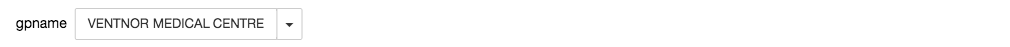

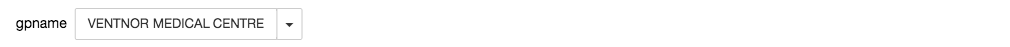

In [67]:
from ipywidgets import interact
interact(generate_map_from_gpname, gpname=iw_gps);